# Terry Stops
## Overview
There has been tension between law enforcement and the public due to the `reasonable suspicion` notion. Through this data, I'll analyze the data to predict whether an arrest was made after a `Terry Stop`.

## Objective
Build a model that will predict, given the data, whether an arrest was made after a Terry stop.

## Methodology
1. `Data Exploration` : Examine the data structure and content, identify relevant variables and understand their meaning and distribution.

2. `Analysis` : Generate descriptive statistics and visualizations to gain insight into the patterns of Terry stops.

3. `Predictive Modeling` : Create models that will predict whether an arrest was made after a Terry stop.
 

## Data Understanding
The dataset contains various attributes related to the stops, including demographic information, stop location, stop reasoning, and outcomes.
his data represents records of police reported stops under Terry v. Ohio, 392 U.S. 1 (1968). Each row represents a unique stop.

- Each record contains perceived demographics of the subject, as reported by the officer making the stop and officer demographics as reported to the Seattle Police Department, for employment purposes.
### Data description

`Subject Age Group`: Subject Age Group (10 year increments) as reported by the officer.

`Subject ID`: Key, generated daily, identifying unique subjects in the dataset using a character to character match of first name and last name. "Null" values indicate an "anonymous" or "unidentified" subject. 

`GO / SC Num`: General Offense or Street Check number, relating the Terry Stop to the parent report. This field may have a one to many relationship in the data.

`Terry Stop ID`: Key identifying unique Terry Stop reports.

`Stop Resolution`: Resolution of the stop as reported by the officer.

`Weapon Type`: Type of weapon, if any, identified during a search or frisk of the subject. Indicates "None" if no weapons was found.

`Officer ID`: Key identifying unique officers in the dataset.

`Officer YOB`: Year of birth, as reported by the officer.

`Officer Gender`: Gender of the officer, as reported by the officer.

`Officer Race`: Race of the officer, as reported by the officer.

`Subject Perceived Race`: Perceived race of the subject, as reported by the officer.

`Subject Perceived Gender`: Perceived gender of the subject, as reported by the officer.

`Reported Date`: Date the report was filed in the Records Management System (RMS). Not necessarily the date the stop occurred but generally within 1 day.

`Reported Time`: Time the stop was reported in the Records Management System (RMS). Not the time the stop occurred but generally within 10 hours.

`Initial Call Type`: Initial classification of the call as assigned by 911.

`Final Call Type`: Final classification of the call as assigned by the primary officer closing the event.

`Call Type`: How the call was received by the communication center.

`Officer Squad`: Functional squad assignment (not budget) of the officer as reported by the Data Analytics Platform (DAP).

`Arrest Flag`: Indicator of whether a "physical arrest" was made, of the subject, during the Terry Stop. Does not necessarily reflect a report of an arrest in the Records Management System (RMS).

`Frisk Flag`: Indicator of whether a "frisk" was conducted, by the officer, of the subject, during the Terry Stop.

`Precinct`: Precinct of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.

`Sector`: Sector of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.

`Beat`: Beat of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.


In [1]:
from imports.functions import *
%matplotlib inline


In [2]:
# creating a dataframe
df = pd.read_csv('data/Terry_Stops.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,36 - 45,7726342469,20200000112069,12803715000,Field Contact,-,6953,1968,M,White,...,19:28:18.0000000,"DISTURBANCE, MISCELLANEOUS/OTHER",--DISTURBANCE - OTHER,911,NaN,N,N,North,N,N2
1,46 - 55,17544297314,20210000007572,19456101086,Field Contact,-,6678,1970,M,White,...,06:01:35.0000000,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,NaN,N,N,North,U,U2
2,26 - 35,-1,20150000005079,88327,Field Contact,None,6382,1958,M,Nat Hawaiian/Oth Pac Islander,...,16:14:00.0000000,-,-,-,NORTH PCT 2ND W - JOHN - PLATOON 1,N,N,-,-,-
3,-,31307974123,20220000015393,31308022368,Field Contact,-,6799,1976,M,Hispanic or Latino,...,13:34:08.0000000,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,NaN,N,N,West,M,M3
4,26 - 35,7727242683,20190000195849,8258954520,Field Contact,-,6953,1968,M,White,...,16:06:48.0000000,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,NaN,N,N,North,N,N3


In [3]:
# checking data details
info(df)

,Column,Missing Percentage,Missing Values,Length,Data type
17,Officer Squad,38.8,930838,2399030,object
0,Subject Age Group,0.0,0,2399030,object
12,Reported Date,0.0,0,2399030,object
21,Sector,0.0,0,2399030,object
20,Precinct,0.0,0,2399030,object
19,Frisk Flag,0.0,0,2399030,object
18,Arrest Flag,0.0,0,2399030,object
16,Call Type,0.0,0,2399030,object
15,Final Call Type,0.0,0,2399030,object
14,Initial Call Type,0.0,0,2399030,object


- `Officer Squad` has about 38.8 percent of missing data which translates to 930838 rows. From the total number of rows available and what the data in this squad signifies, I'll drop just the missing rows since the remaining data is sufficient.


In [4]:
# dropping null values
df.dropna(inplace=True)

In [5]:
# investigating the Beat column
df.Beat.value_counts()

-     383904
N3     50482
E2     45107
K3     40807
M2     36593
M3     33927
N2     30358
E1     30014
R2     28810
B1     27606
U2     27262
M1     26918
F2     26574
K2     25843
B2     25069
D1     24725
L1     24467
L3     23005
L2     23005
S2     22747
D2     22747
E3     21414
O1     21070
S3     20812
K1     19135
Q3     19135
J1     19049
B3     18490
F3     17888
U1     17587
G2     17544
R1     17458
D3     17329
W2     16426
R3     16297
J3     16168
G3     16125
C3     15394
C1     15351
O2     14663
S1     14190
F1     14147
O3     14104
W1     14018
Q2     13416
N1     13244
J2     12857
C2     11739
G1     11180
U3     11094
W3      9804
Q1      8729
99      2279
S         86
Name: Beat, dtype: int64

It has `-` as the most occuring value, I'll change that to `unknown`

In [6]:
# replacing values in column Beat
replace(df, 'Beat', '-', 'Unknown')

Unknown    383904
N3          50482
E2          45107
K3          40807
M2          36593
M3          33927
N2          30358
E1          30014
R2          28810
B1          27606
U2          27262
M1          26918
F2          26574
K2          25843
B2          25069
D1          24725
L1          24467
L3          23005
L2          23005
S2          22747
D2          22747
E3          21414
O1          21070
S3          20812
K1          19135
Q3          19135
J1          19049
B3          18490
F3          17888
U1          17587
G2          17544
R1          17458
D3          17329
W2          16426
R3          16297
J3          16168
G3          16125
C3          15394
C1          15351
O2          14663
S1          14190
F1          14147
O3          14104
W1          14018
Q2          13416
N1          13244
J2          12857
C2          11739
G1          11180
U3          11094
W3           9804
Q1           8729
99           2279
S              86
Name: Beat, dtype: int64

# Feature Engineering

Some of the columns contain data that is not useful as it is. I'll use various techniques to create new features and drop the original columns.

In [7]:
#The column for officer year of birth will be dropped and instead will use age
# I'll use the reporting date to calculate the age at the time of reporting
# Convert strings to datetime objects

df['Reported Date'] = pd.to_datetime(df['Reported Date'])
df['Officer YOB'] = pd.to_numeric(df['Officer YOB'], errors='coerce')

df['age'] = df['Reported Date'].dt.year - df['Officer YOB']





In [8]:
# investigating age column
print(f"Youngest: {df['age'].min()}")
print(f"Oldest: {df['age'].max()}")

Youngest: 21
Oldest: 119


Given that in Seattle the minimum age to enroll at the time of this project is 20.5 years and the retirement age is 65, we will drop any that are below 21 and above 65

In [9]:
# dropping officers who were above 65 or below 21 by the time of the stop
df = df[(df['age'] <= 65) & (df['age'] >= 21)]


In [10]:
# investigating age column
print(f"Youngest: {df['age'].min()}")
print(f"Oldest: {df['age'].max()}")

Youngest: 21
Oldest: 65


In the `weapon type` column, there are different types that can be grouped together.

In [11]:
df['Weapon Type'].value_counts()

None                               1383611
Lethal Cutting Instrument            62952
Handgun                               9804
Firearm Other                         4257
-                                     2623
Club, Blackjack, Brass Knuckles       2107
Firearm (unk type)                     645
Club                                   387
Rifle                                  172
Shotgun                                129
Automatic Handgun                       86
Brass Knuckles                          43
Blackjack                               43
Name: Weapon Type, dtype: int64

In [12]:
# replacing
replace(df, 'Weapon Type', '-', 'Unknown')
replace(df, 'Weapon Type', ['Handgun', 'Firearm Other', 'Firearm (unk type)',
                            'Other Firearm', 'Rifle', 'Shotgun', 'Automatic Handgun'],'Firearm')
replace(df, 'Weapon Type', ['Club, Blackjack, Brass Knuckles', 'Blackjack', 'Brass Knuckles', 
                            'Club', 'Personal Weapons (hands, feet, etc.)'], 'Striking Object')

None                         1383611
Lethal Cutting Instrument      62952
Firearm                        15093
Unknown                         2623
Striking Object                 2580
Name: Weapon Type, dtype: int64

In [13]:
cols = ['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Officer YOB', 'Initial Call Type', 
        'Arrest Flag', 'Reported Date', 'Sector', 'Officer ID', 'Beat']
drop(df, cols)

Number of columns before dropping: 24
Number of columns after dropping: 14


In [14]:
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Time,Final Call Type,Call Type,Officer Squad,Frisk Flag,Precinct,age
2,26 - 35,Field Contact,None,M,Nat Hawaiian/Oth Pac Islander,White,Male,16:14:00.0000000,-,-,NORTH PCT 2ND W - JOHN - PLATOON 1,N,-,57
6,26 - 35,Field Contact,None,M,White,White,Male,16:56:00.0000000,-,-,WEST PCT 2ND W - D/M RELIEF,N,-,33
7,56 and Above,Offense Report,None,M,White,White,Male,17:38:00.0000000,--DV - ASSIST VICTIM BY COURT ORDER,911,SOUTH PCT 2ND W - ROBERT - PLATOON 2,N,South,27
9,26 - 35,Offense Report,None,M,Hispanic or Latino,White,Male,00:52:00.0000000,"--ASSAULTS, OTHER",ONVIEW,EAST PCT 2ND W - CHARLIE RELIEF,N,East,28
10,18 - 25,Offense Report,Lethal Cutting Instrument,M,Hispanic or Latino,White,Male,02:34:00.0000000,--DISTURBANCE - OTHER,911,EAST PCT 3RD W - E/G RELIEF,Y,East,26


In [15]:
replace(df, 'Final Call Type', '-', 'Unknown')

Unknown                                     532598
--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON     88064
--PROWLER - TRESPASS                         83549
--DISTURBANCE - OTHER                        76497
--ASSAULTS, OTHER                            68198
                                             ...  
FIGHT - JO - PHYSICAL (NO WEAPONS)              43
ASLT - IP/JO - DV                               43
SHOTS -DELAY/INCLUDES HEARD/NO ASSAULT          43
UNKNOWN - COMPLAINT OF UNKNOWN NATURE           43
--HARBOR - ASSIST BOATER (NON EMERG)            43
Name: Final Call Type, Length: 160, dtype: int64

In [16]:
replace(df, 'Precinct', '-', 'Unknown')

Unknown      386011
North        338969
West         289218
East         183868
South        169979
Southwest     98814
Name: Precinct, dtype: int64

In [17]:
replace(df, 'Call Type', '-', 'Unknown')

911                              602817
Unknown                          532598
ONVIEW                           229749
TELEPHONE OTHER, NOT 911          94729
ALARM CALL (NOT POLICE ALARM)      6880
SCHEDULED EVENT (RECURRING)          43
TEXT MESSAGE                         43
Name: Call Type, dtype: int64

In [18]:
replace(df, 'Subject Age Group', '-', 'Unknown')

26 - 35         489297
18 - 25         316050
36 - 45         297001
46 - 55         184126
1 - 17           70692
56 and Above     66607
Unknown          43086
Name: Subject Age Group, dtype: int64

In [19]:
replace(df, 'Subject Perceived Race', '-', 'Unknown')

White                               732032
Black or African American           445007
Unknown                              86645
Hispanic                             71896
American Indian or Alaska Native     46741
Asian                                43602
Multi-Racial                         34443
Other                                 6493
Name: Subject Perceived Race, dtype: int64

In [20]:
replace(df, 'Subject Perceived Gender', '-', 'Unknown')

Male                   1138984
Female                  304612
Unable to Determine      13588
Unknown                   9675
Name: Subject Perceived Gender, dtype: int64

In [21]:
replace(df, 'Frisk Flag', '-', 'Unknown')

N          1131459
Y           315190
Unknown      20210
Name: Frisk Flag, dtype: int64

In [22]:
df['Reported Time'] = df['Reported Time'].str[:5]

In [23]:
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Time,Final Call Type,Call Type,Officer Squad,Frisk Flag,Precinct,age
2,26 - 35,Field Contact,None,M,Nat Hawaiian/Oth Pac Islander,White,Male,16:14,Unknown,Unknown,NORTH PCT 2ND W - JOHN - PLATOON 1,N,Unknown,57
6,26 - 35,Field Contact,None,M,White,White,Male,16:56,Unknown,Unknown,WEST PCT 2ND W - D/M RELIEF,N,Unknown,33
7,56 and Above,Offense Report,None,M,White,White,Male,17:38,--DV - ASSIST VICTIM BY COURT ORDER,911,SOUTH PCT 2ND W - ROBERT - PLATOON 2,N,South,27
9,26 - 35,Offense Report,None,M,Hispanic or Latino,White,Male,00:52,"--ASSAULTS, OTHER",ONVIEW,EAST PCT 2ND W - CHARLIE RELIEF,N,East,28
10,18 - 25,Offense Report,Lethal Cutting Instrument,M,Hispanic or Latino,White,Male,02:34,--DISTURBANCE - OTHER,911,EAST PCT 3RD W - E/G RELIEF,Y,East,26


In [24]:
df['Stop Resolution'].unique()

array(['Field Contact', 'Offense Report', 'Arrest',
       'Citation / Infraction', 'Referred for Prosecution'], dtype=object)

The target column can then be engineered to contain binary according to the outcome of the stop.
From the above cell, there are 5 different outcomes, I'll combine them according to the severity of the outcome
- `1` means `Arrest` while `0` means `No Arrest`.

In [25]:
replace(df, 'Stop Resolution', ['Field Contact', 'Citation / Infraction'] , 0)

replace(df, 'Stop Resolution', ['Offense Report', 'Arrest', 'Referred for Prosecution'], 1)



1    931165
0    535694
Name: Stop Resolution, dtype: int64

In [26]:
info(df)

,Column,Missing Percentage,Missing Values,Length,Data type
0,Subject Age Group,0.0,0,1466859,object
1,Stop Resolution,0.0,0,1466859,int64
2,Weapon Type,0.0,0,1466859,object
3,Officer Gender,0.0,0,1466859,object
4,Officer Race,0.0,0,1466859,object
5,Subject Perceived Race,0.0,0,1466859,object
6,Subject Perceived Gender,0.0,0,1466859,object
7,Reported Time,0.0,0,1466859,object
8,Final Call Type,0.0,0,1466859,object
9,Call Type,0.0,0,1466859,object


In [27]:
# Removing minutes in time by rounding to the next hour
df['Reported Time'] = df['Reported Time'].apply(round_time)


In [28]:
df['Subject Age Group'].unique()

array(['26 - 35', '56 and Above', '18 - 25', '46 - 55', 'Unknown',
       '36 - 45', '1 - 17'], dtype=object)

Using the age groups in subjects, I will create similar groups for the police.

In [29]:
df['Officer Age Group'] = df['age'].apply(map_age)

In [30]:
df.drop('age', axis=1, inplace=True)

In [31]:
df['Reported Time'] = df['Reported Time'].apply(map_time)

In [32]:
df['Final Call Type'] = df['Final Call Type'].apply(call_group)

In [33]:
df['Officer Squad'] = df['Officer Squad'].apply(squad_groups)

In [34]:
info(df)

,Column,Missing Percentage,Missing Values,Length,Data type
0,Subject Age Group,0.0,0,1466859,object
1,Stop Resolution,0.0,0,1466859,int64
2,Weapon Type,0.0,0,1466859,object
3,Officer Gender,0.0,0,1466859,object
4,Officer Race,0.0,0,1466859,object
5,Subject Perceived Race,0.0,0,1466859,object
6,Subject Perceived Gender,0.0,0,1466859,object
7,Reported Time,0.0,0,1466859,object
8,Final Call Type,0.0,0,1466859,object
9,Call Type,0.0,0,1466859,object


# Modelling

In [35]:
X = df.drop('Stop Resolution', axis=1)
y = df['Stop Resolution']

The target variable and the features are separated.

In [36]:
info(df)

,Column,Missing Percentage,Missing Values,Length,Data type
0,Subject Age Group,0.0,0,1466859,object
1,Stop Resolution,0.0,0,1466859,int64
2,Weapon Type,0.0,0,1466859,object
3,Officer Gender,0.0,0,1466859,object
4,Officer Race,0.0,0,1466859,object
5,Subject Perceived Race,0.0,0,1466859,object
6,Subject Perceived Gender,0.0,0,1466859,object
7,Reported Time,0.0,0,1466859,object
8,Final Call Type,0.0,0,1466859,object
9,Call Type,0.0,0,1466859,object


## Splitting the data

Split into train and test data.
- This will be done twice so that the final model can be evaluated on data that has not been touched at all.
- `X_train_second`, `X_test_second`, `y_train_second` and `y_train_second` will be used for the initial models.

In [37]:
df.shape

(1466859, 14)

In [38]:
# first split
X_train_first, X_test_first, y_train_first, y_test_first = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
print(f'Shape of X_train: {X_train_first.shape}')
print('=========================================')
print(f'Shape of y_train: {y_train_first.shape}')

Shape of X_train: (1100144, 13)
Shape of y_train: (1100144,)


In [40]:
# second split
X_train_second, X_test_second, y_train_second, y_test_second = train_test_split(X_train_first, y_train_first, test_size=0.25, random_state=42)

In [41]:
print(f'Shape of X_train: {X_train_second.shape}')
print('=========================================')
print(f'Shape of y_train: {y_train_second.shape}')

Shape of X_train: (825108, 13)
Shape of y_train: (825108,)


## Feature Encoding

In [42]:
# using OneHotEncoder to transform the columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_ohe = ohe.fit_transform(X_train_second)
X_test_ohe = ohe.transform(X_test_second)

In [43]:
# get the column names for the one-hot encoded features
column_names = ohe.get_feature_names(X_train_second.columns)
    
# create a new DataFrame with the one-hot encoded features
df_encoded = pd.DataFrame(X_train_ohe, columns=column_names)

# First Model - Logistic Regression
- This will be a baseline model.

In [44]:
# instantiating and fitting
logreg = LogisticRegression(random_state=42)

first_model = logreg.fit(X_train_ohe, y_train_second)

In [45]:
# generating predictions
y_hat_train = logreg.predict(X_train_ohe)
y_hat_test = logreg.predict(X_test_ohe)

In [46]:
# checking scores
calc_scores(y_train_second, y_hat_train, y_test_second, y_hat_test)

F1 score for training data: 0.9440378438825444
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.9437992966698948
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.9453978874046238
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.9453792093033904
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.9426817078394973
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.9422246559090105


### Review

For a baseline model, this are great scores. The `F1 Score` of `0.94` shows the average between recall and precision.<br>
We can further see the `recall score` and `precision score` are `0.94`. <br>
Due to the nature of our target, the `reacll score` will be the best score to consider.


In [47]:
cf_log_train = confusion_matrix(y_train_second, y_hat_train)
cf_log_test = confusion_matrix(y_test_second, y_hat_test)

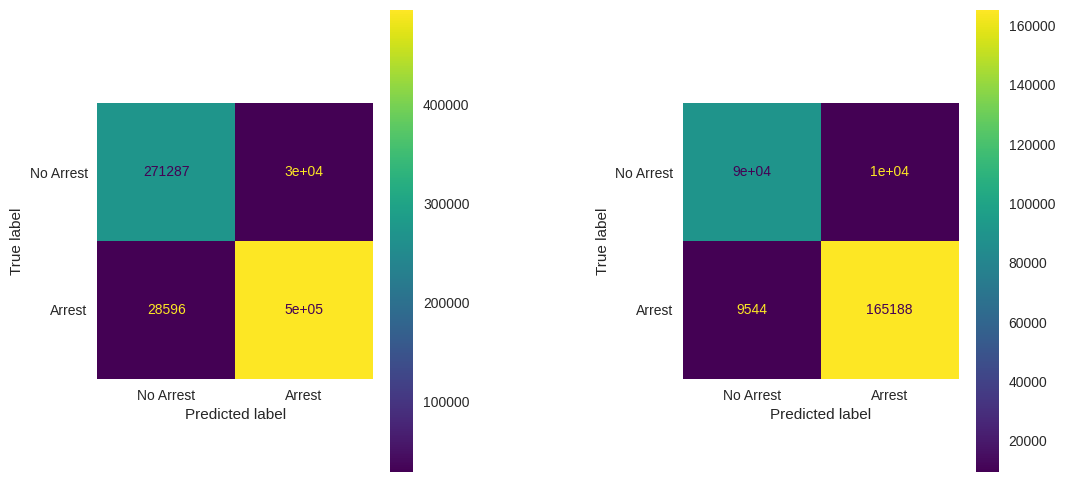

In [58]:
label_dict = {0: 'No Arrest', 1: 'Arrest'}

# Extract the labels from the dictionary keys
labels = [label_dict[key] for key in sorted(label_dict.keys())]
disp = ConfusionMatrixDisplay(confusion_matrix=cf_log_train, display_labels=labels)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cf_log_test, display_labels=labels)

# Create the subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the confusion matrix on the first subplot
disp.plot(ax=ax1)
ax1.grid(False)

# Plot the confusion matrix on the second subplot
disp2.plot(ax=ax2)
ax2.grid(False)
plt.subplots_adjust(wspace=0.7)
# Show the plot
plt.show()


The confusion matrix shows that the model correctly predicts `165188` as `Arrest` and `90000` as `Not arrest`.<br>
Although there are still some few that it predicts wrong

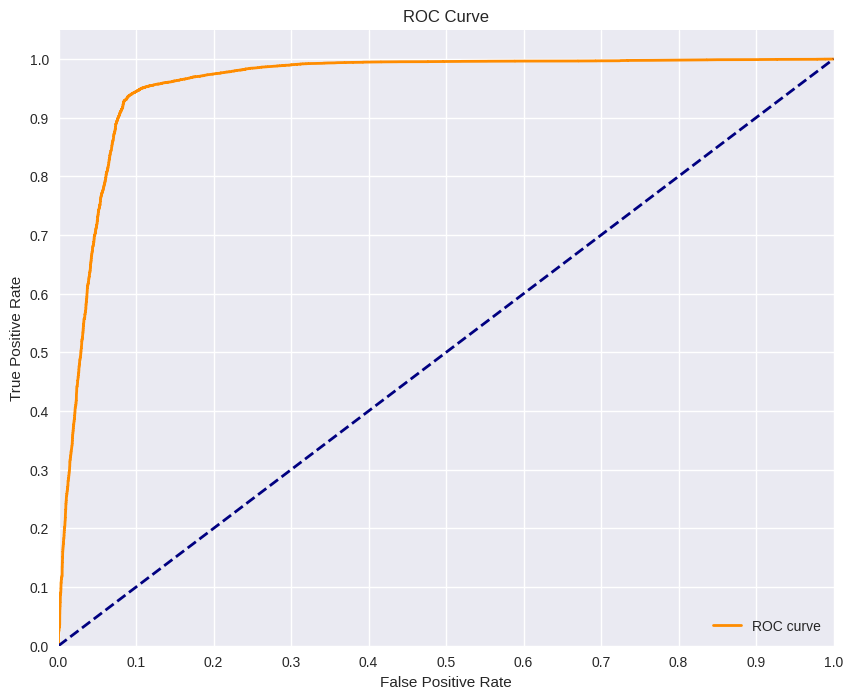

AUC: 0.9573500836010824


In [48]:
# plotting a ROC curve
roc_auc_plot(X_train_ohe, y_train_second, X_test_ohe, y_test_second, logreg)


The `AUC` of `0.9573500836010824` indicates a high level of performance for the model.
This means that the model quality of prediction is great across all thresholds and performs well in classifying the target variable.



# Second Model - DECISION TREE
Given the scores the first model produced, the second model should hopefully improve on that

In [49]:
# instantiating and fitting
dt = DecisionTreeClassifier()
dt.fit(X_train_ohe, y_train_second)


DecisionTreeClassifier()

In [50]:
y_preds_train = dt.predict(X_train_ohe)
y_preds_test = dt.predict(X_test_ohe)

In [51]:
calc_scores(y_train_second, y_preds_train, y_test_second, y_preds_test)

F1 score for training data: 0.9909083705428534
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.9901357196804981
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.9909225610827243
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.9903623835359293
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.9908941804094087
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.9899091595542641


In [63]:
cf = confusion_matrix(y_train_second, y_preds_train)
cf2 = confusion_matrix(y_test_second, y_preds_test)

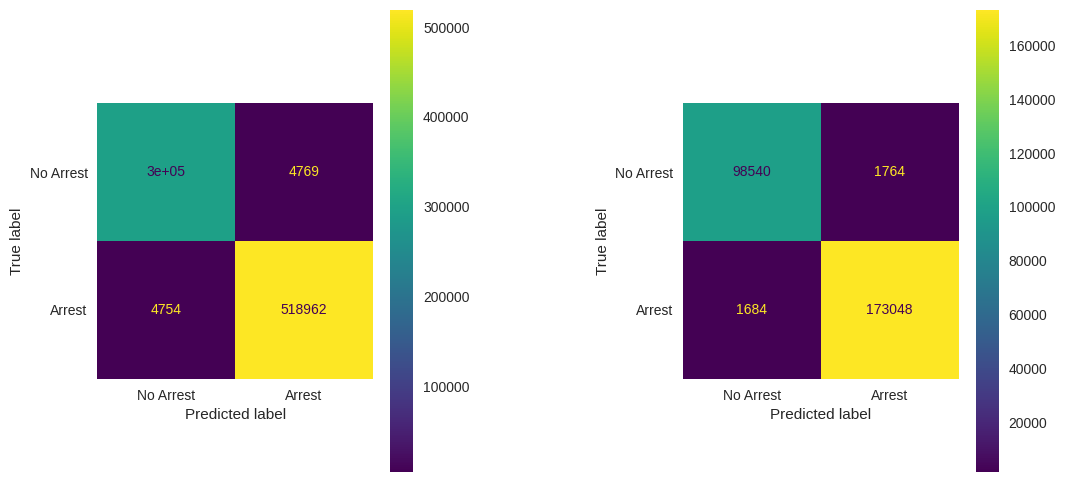

In [92]:
# Create the ConfusionMatrixDisplay objects
labels = ['No Arrest', 'Arrest']
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=labels)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cf2, display_labels=labels)

# Create the subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the confusion matrix on the first subplot
disp.plot(ax=ax1)
ax1.grid(False)

# Plot the confusion matrix on the second subplot
disp2.plot(ax=ax2)
ax2.grid(False)
plt.subplots_adjust(wspace=0.7)
# Show the plot
plt.show()
